## NLP要解决的任务：
- 1.处理文本数据，首先对文本数据进行分词操作（分词的方法可能不同，中文常见的就是分词或者分字）
- 2.分完的词它步还是字符嘛，计算机还不认识，最终我们希望把这些字符映射成实际的特征（向量）
- 3.输入搞定好之后，接下来咱们构建模型了（一般都用预训练模型，例如BERT，GPT系列等）
- 4.怎么去完成我们自己的任务呢，基本上就是在预训练模型的基础上进行微调（训练我们自己数据的过程）

## 先来瞅瞅多简单就干了一个大活
- Huggingface这个包基本上就是调用即可，开箱即用的过程

In [1]:
import warnings
warnings.filterwarnings('ignore')
from transformers import pipeline  # 用人家设计好的流程完成一些简单的任务
classifier=pipeline('sentiment-analysis')
classifier(
[
    " I've been waiting for a HuggingFace course my whole life",
    "I hate this so much"
]
)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9516069889068604},
 {'label': 'NEGATIVE', 'score': 0.9995144605636597}]

基本流程概述分析

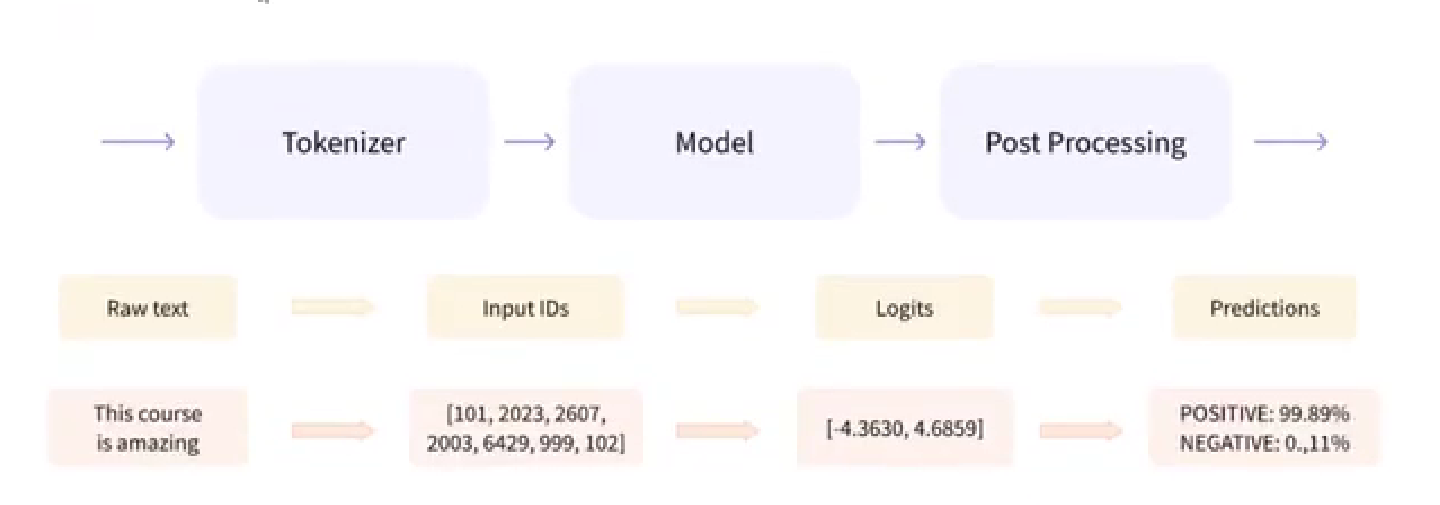


## Tokenizer要做的事：
- 分词，分字以及特殊字符（起始，终止，间隔，分类等特殊字符可以自己设计的）
- 对每一个token映射得到一个ID（每个词都会对应一个唯一的ID）
- 还有一些辅助信息也可以得到，比如当前词属于哪个句子（还有一些MASK，表示是否是原理的词还是特殊字符）

In [2]:
from transformers import AutoTokenizer # 自动判断

checkpoint='distilbert-base-uncased-finetuned-sst-2-english'#根据这个模型所对应的来加载
tokenizer=AutoTokenizer.from_pretrained(checkpoint)

In [3]:
raw_inputs=[
    "I've been waiting for a this course my whole life.",
    "I hate this so much"
]
inputs=tokenizer(raw_inputs,padding=True,truncation=True,return_tensors='pt')
print(inputs)

{'input_ids': tensor([[ 101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878,
         2166, 1012,  102],
        [ 101, 1045, 5223, 2023, 2061, 2172,  102,    0,    0,    0,    0,    0,
            0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [4]:
tokenizer.decode([ 101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878,2166, 1012,  102])

"[CLS] i've been waiting for a this course my whole life. [SEP]"

这些特殊字符是因为人家模型训练的时候就加入了这个东西，所以这里默认页加入了

## 模型的加载方法很简单
- 直接指定好名字即可，这里我们先不加输出层

In [5]:
from transformers import AutoModel#自动选模型
checkpoint='distilbert-base-uncased-finetuned-sst-2-english'
model=AutoModel.from_pretrained(checkpoint)

In [6]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

## 模型结构读取
这是一个基于 DistilBERT 模型的简化版本的结构示例。DistilBERT 是一个经过精简的 BERT 模型，仍保留了大部分原始模型的性能，同时具有更小的参数规模和更快的推理速度。以下是这个模型的主要组件：

### Embeddings 层
- `word_embeddings`: 将输入的 token ID 映射为对应的词嵌入（Embedding）表示。这里的形状是 `(30522, 768)`，其中 `30522` 是词汇表的大小，`768` 是每个词嵌入的维度。
  
- `position_embeddings`: 用于表示输入序列中每个位置的位置嵌入。这里的形状是 `(512, 768)`，其中 `512` 是序列的最大长度，`768` 是每个位置的位置嵌入的维度。

- `LayerNorm`: 应用 Layer Normalization 进行归一化处理，这有助于减少训练时的内部协变量偏移（Internal Covariate Shift）。

- `dropout`: 在模型训练过程中应用的 Dropout 层，有助于防止过拟合。

### Transformer 层
这里包含了多个 TransformerBlock，每个 Block 包含以下组件：

#### MultiHeadSelfAttention
- `q_lin`, `k_lin`, `v_lin`: 通过线性变换将输入的嵌入分别映射为查询（query）、键（key）、值（value）向量。
  
- `out_lin`: 将经过注意力计算后的结果映射为最终的输出向量。

#### LayerNorm
- `sa_layer_norm`: 自注意力层后的 Layer Normalization。

#### FeedForward Network (FFN)
- `lin1`, `lin2`: 两个线性层，通过激活函数 GELUActivation 连接。
  
- `activation`: GELU 激活函数，一种非线性激活函数，通常用于 Transformer 模型中。

#### Output Layer Norm
- `output_layer_norm`: 最终的输出层 Layer Normalization。

这个模型的整体架构是一个层叠的 TransformerBlock，每个 Block 包含了自注意力机制和前馈神经网络（FeedForward Neural Network）两个主要组件。通过这些组件的堆叠，模型能够捕捉输入序列中的上下文信息，并生成相应的输出表示。

这是一个典型的 Transformer 模型结构，在 NLP 任务中被广泛应用，如语言建模、命名实体识别、文本分类等。DistilBERT 通过对 BERT 模型进行压缩，提供了一个更加轻量级的选择，适用于资源受限的环境或需要快速推理的场景。

In [7]:
outputs=model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 15, 768])


## 模型基本逻辑
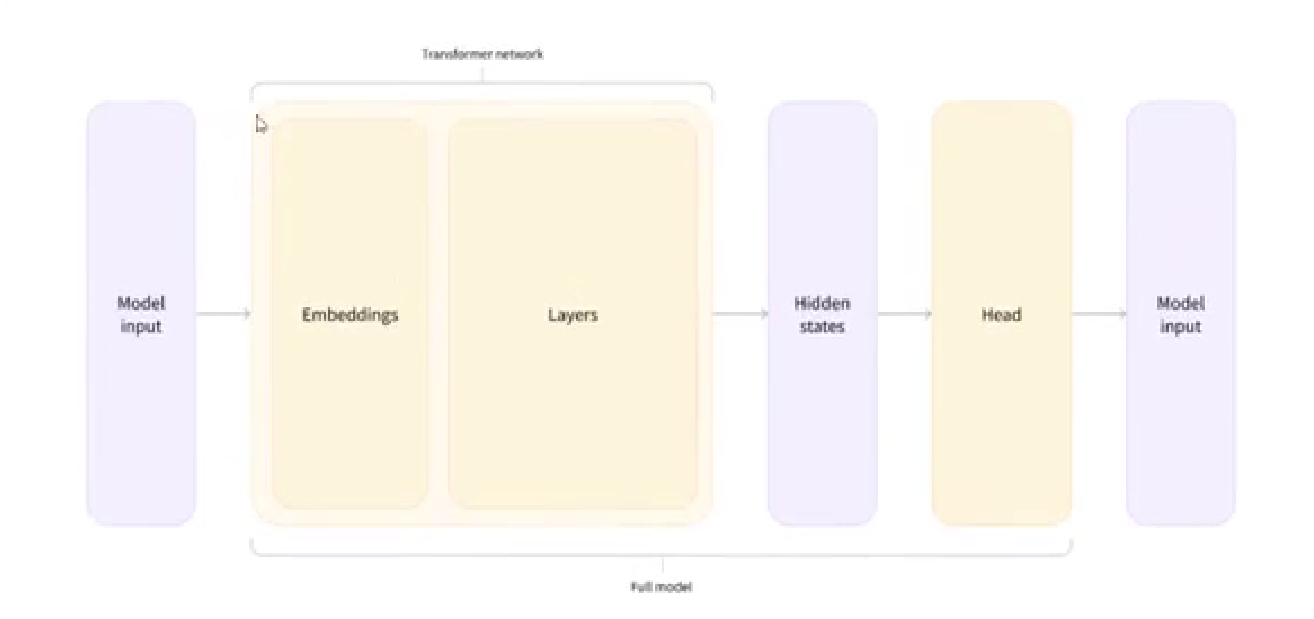

## 输出头我们也可以一并加上

In [8]:
from transformers import AutoModelForSequenceClassification

checkpoint='distilbert-base-uncased-finetuned-sst-2-english'
model=AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs=model(**inputs)
print(outputs.logits.shape)

torch.Size([2, 2])


In [9]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [10]:
import torch
predictions=torch.nn.functional.softmax(outputs.logits,dim=-1)
print(predictions)

tensor([[1.5446e-02, 9.8455e-01],
        [9.9951e-01, 4.8549e-04]], grad_fn=<SoftmaxBackward0>)


id2label这个我们后续可以自己设计，标签名字对应都可以自己指定

In [11]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

## padding的作用

In [12]:
sequence1_ids=[[200,200,200]]
sequence2_ids=[[200,200]]

batched_ids=[
    [200,200,200],
    [200,200,tokenizer.pad_token_id],
]

print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)

print(model(torch.tensor(batched_ids)).logits)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)
tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5694, -1.3895],
        [ 1.3374, -1.2163]], grad_fn=<AddmmBackward0>)


为啥结果会不一样呢？

## attention_mask的作用

In [13]:
batched_ids=[
    [200,200,200],
    [200,200,tokenizer.pad_token_id],
]

attention_mask=[
    [1,1,1],
    [1,1,0]
]
outputs=model(torch.tensor(batched_ids),attention_mask=torch.tensor(attention_mask))
print(outputs.logits)

tensor([[ 1.5694, -1.3895],
        [ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)


## 不同的padding方法

In [14]:
sequences=["I've been waiting for a this course my whole life.","So have I!","I played basketball yesterday"]

In [15]:
# 按照最长的填充
model_inputs=tokenizer(sequences,padding="longest")
model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2209, 3455, 7483, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [16]:
# BERT默认最大是512
model_inputs=tokenizer(sequences,padding="max_length")
model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878, 2166, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
# 填充到多少
model_inputs=tokenizer(sequences,padding='max_length',max_length=8)
model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102, 0, 0], [101, 1045, 2209, 3455, 7483, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 0, 0]]}

In [18]:
# 到多少就截断
model_inputs=tokenizer(sequences,max_length=10,truncation=True)
model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 102], [101, 2061, 2031, 1045, 999, 102], [101, 1045, 2209, 3455, 7483, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

In [19]:
# 最好返回tensor
model_inputs=tokenizer(sequences,padding=True,return_tensors='pt')
model_inputs

{'input_ids': tensor([[ 101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878,
         2166, 1012,  102],
        [ 101, 2061, 2031, 1045,  999,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0],
        [ 101, 1045, 2209, 3455, 7483,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}